# Import packages and datasets

In [1]:
# Importing course packages; you can add more too!
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
datadir = '../datasets/raw'

In [3]:
# Importing course datasets as DataFrames
anscombe = pd.read_csv(os.path.join(datadir,'anscombe.csv'), header=[0,1])
bees = pd.read_csv(os.path.join(datadir,'bee_sperm.csv'), comment='#')
literacy_fertility = pd.read_csv(os.path.join(datadir,'female_literacy_fertility.csv'))
beaks_1975 = pd.read_csv(os.path.join(datadir,'finch_beaks_1975.csv'))
beaks_2012 = pd.read_csv(os.path.join(datadir,'finch_beaks_2012.csv'))
frogs = pd.read_csv(os.path.join(datadir,'frog_tongue.csv'), comment='#')
mlb = pd.read_csv(os.path.join(datadir,'mlb_nohitters.csv'))
weather = pd.read_csv(os.path.join(datadir,'sheffield_weather_station.csv'), comment='#', delimiter='\s+', na_values='---')

## pre-defined functions

In [4]:
""" Empirical cumulative distribution function (ECDF) """
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x)+1) / n

    return x, y

In [5]:
""" Pearson correlation coefficient """
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [6]:
""" Bootstrap Replicates """

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [7]:
""" Pairs Bootstrap for Linear Regression """
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)  # 1: linear fit

    return bs_slope_reps, bs_intercept_reps

In [8]:
""" Permutation of two sample data sets """
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [9]:
""" Permutation Replicates """
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [10]:
""" difference of means of two arrays """
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [11]:
""" pairs bootstrap for a single statistics """
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

# Parameter estimation by optimization

The number of games played between each no-hitter in the modern era (1901-2015) of Major League Baseball.
If you assume that no-hitters are described as a Poisson process, then the time between no-hitters is Exponentially distributed. 

In [12]:
# array copied from datacamp directly
nohitter_times = np.array([843,1613,1101,215,684,814,278,324,161,219,545,715,966,624,29,450,107, \
                           20,91,1325,124,1468,104,1309,429,62,1878,1104,123,251,93,188,983,166,96,\
                           702,23,524,26,299,59,39,12,2,308,1114,813,887,645,2088,42,2090,11,886,\
                           1665,1084,2900,2432,750,4021,1070,1765,1322,26,548,1525,77,2181,2752,127,\
                           2147,211,41,1575,151,479,697,557,2267,542,392,73,603,233,255,528,397,1529,\
                           1023,1194,462,583,37,943,996,480,1497,717,224,219,1531,498,44,288,267,600,\
                           52,269,1086,386,176,2199,216,54,675,1243,463,650,171,327,110,774,509,8,197,\
                           136,12,1124,64,380,811,232,192,731,715,226,605,539,1491,323,240,179,702,156,\
                           82,1397,354,778,603,1001,385,986,203,149,576,445,180,1403,252,675,1351,2983,\
                           1568,45,899,3260,1025,31,100,2055,4043,79,238,3931,2351,595,110,215,0,563,\
                           206,660,242,577,179,157,192,192,1848,792,1693,55,388,225,1134,1172,1555,31,\
                           1582,1044,378,1687,2915,280,765,2819,511,1521,745,2491,580,2072,6450,578,745,\
                           1075,1103,1549,1520,138,1202,296,277,351,391,950,459,62,1056,1128,139,420,87,\
                           71,814,603,1349,162,1027,783,326,101,876,381,905,156,419,239,119,129,467])

print(len(nohitter_times))

251


Text(0, 0.5, 'PDF')

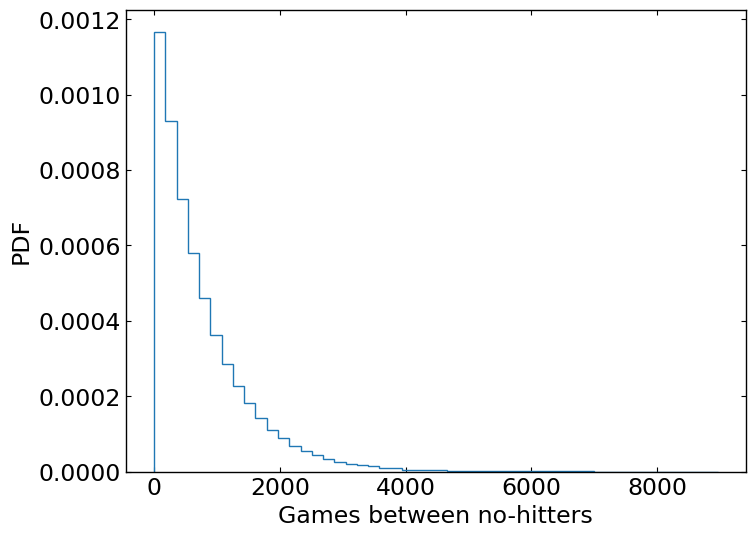

In [13]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = np.mean(nohitter_times)

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100000)

fig, ax = plt.subplots()

# Plot the PDF and label axes
ax.hist(inter_nohitter_time,
             density=True, bins=50, histtype='step')
ax.set_xlabel('Games between no-hitters')
ax.set_ylabel('PDF')

Text(0, 0.5, 'CDF')

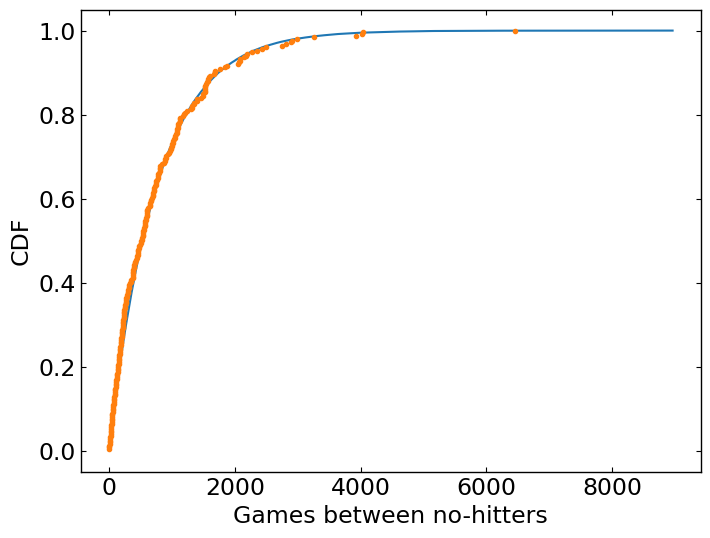

In [14]:
# Create an ECDF from real data: x, y
x, y = ecdf(nohitter_times)

# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

fig, ax = plt.subplots()

# Overlay the plots
ax.plot(x_theor, y_theor)
ax.plot(x, y, marker='.', linestyle='none')

ax.set_xlabel('Games between no-hitters')
ax.set_ylabel('CDF')

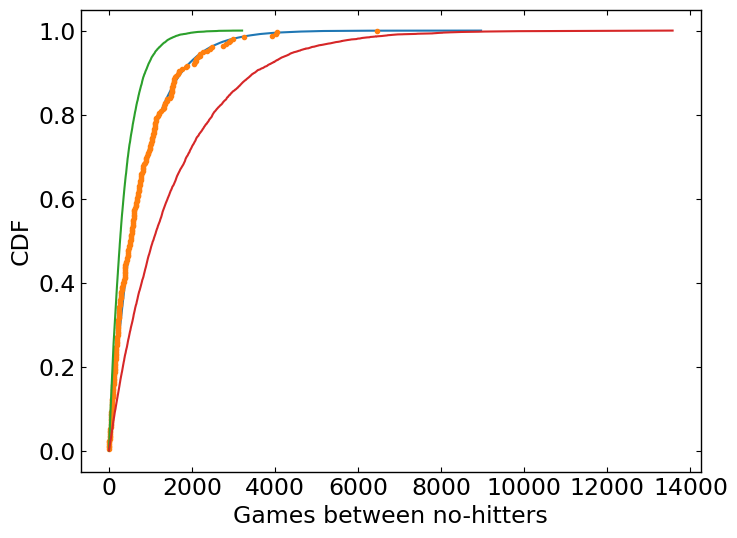

In [15]:
''' Check the parameter optimal '''

fig, ax = plt.subplots()

# Plot the theoretical CDFs
ax.plot(x_theor, y_theor)
ax.plot(x, y, marker='.', linestyle='none')

ax.set_xlabel('Games between no-hitters')
ax.set_ylabel('CDF')

# Take samples with half tau: samples_half
samples_half = np.random.exponential(tau/2, 10000)

# Take samples with double tau: samples_double
samples_double = np.random.exponential(2*tau, 10000)

# Generate CDFs from these samples
x_half, y_half = ecdf(samples_half)
x_double, y_double = ecdf(samples_double)

# Plot these CDFs as lines
ax.plot(x_half, y_half)
ax.plot(x_double, y_double);

## Linear regression by least squares 

we will look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world.

In [16]:
literacy_fertility.head()

,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


In [17]:
# dataframe to numpy array
illiteracy = (100 - literacy_fertility["female literacy"]).to_numpy()
fertility = literacy_fertility.fertility.to_numpy()

0.8041324026815344


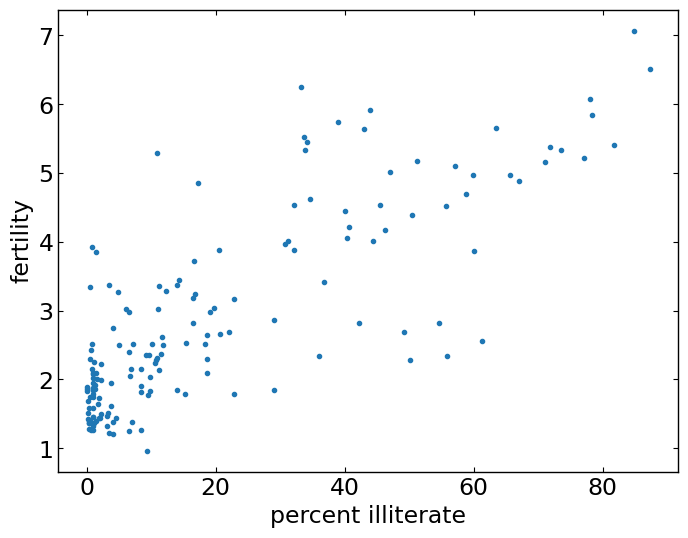

In [18]:
''' EDA of literacy/fertility '''

fig, ax = plt.subplots()

# Plot the illiteracy rate versus fertility
ax.plot(illiteracy, fertility, marker='.', linestyle='none')

ax.set_xlabel('percent illiterate')
ax.set_ylabel('fertility')

# Show the Pearson correlation coefficient
print(pearson_r(illiteracy, fertility))

slope = 0.04979854809063423 children per woman / percent illiterate
intercept = 1.888050610636557 children per woman


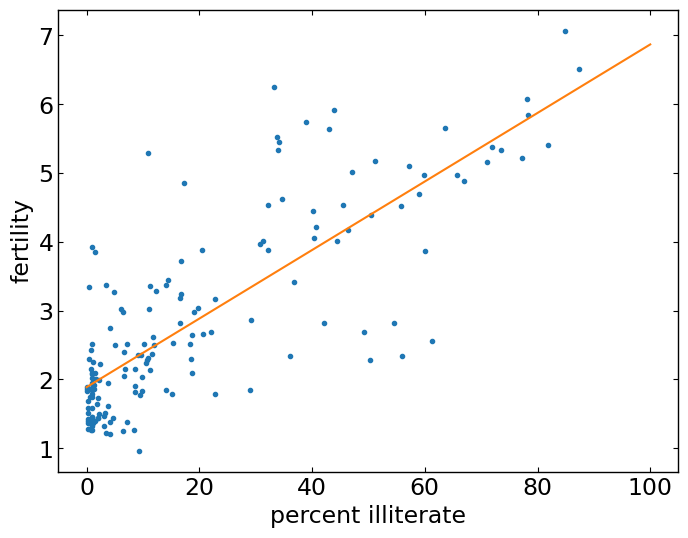

In [19]:
''' Linear regression by np.polyfit '''

fig, ax = plt.subplots()

# Plot the illiteracy rate versus fertility
ax.plot(illiteracy, fertility, marker='.', linestyle='none')

ax.set_xlabel('percent illiterate')
ax.set_ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

# Make theoretical line to plot
x = np.array([0,100])
y = a * x + b

# Add regression line to your plot
ax.plot(x, y);

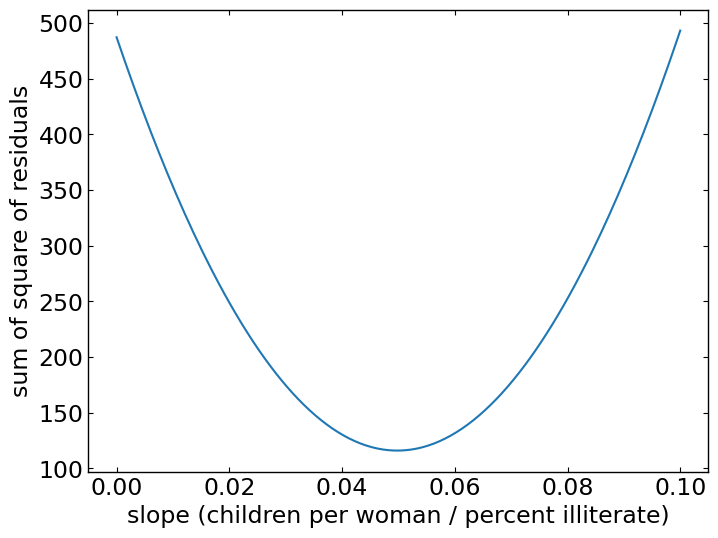

In [20]:
''' Optimal Check '''

# Specify slopes to consider: a_vals
a_vals = np.linspace(0,0.1,200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(a_vals)

# Compute sum of square of residuals for each value of a_vals
for i, a in enumerate(a_vals):
    rss[i] = np.sum((fertility - a * illiteracy - b)**2)

fig, ax = plt.subplots()

# Plot the RSS
ax.plot(a_vals, rss, '-')
ax.set_xlabel('slope (children per woman / percent illiterate)')
ax.set_ylabel('sum of square of residuals');

## Anscombe's quartet

- Every regression parameters are fairly similar !!! 
- Look up (Explore) the data before doing the regression!

In [21]:
anscombe.head()

0           1           2           3      
      x     y     x     y     x      y    x     y
0  10.0  8.04  10.0  9.14  10.0   7.46  8.0  6.58
1   8.0  6.95   8.0  8.14   8.0   6.77  8.0  5.76
2  13.0  7.58  13.0  8.74  13.0  12.74  8.0  7.71
3   9.0  8.81   9.0  8.77   9.0   7.11  8.0  8.84
4  11.0  8.33  11.0  9.26  11.0   7.81  8.0  8.47

In [22]:

x= anscombe["0"]["x"].to_numpy()
y = anscombe["0"]["y"].to_numpy()

In [23]:
''' dataframe to numpy array '''

# to numpy array
arr = anscombe.values.T

# re-arrange the whole array to x & y datasets
anscombe_x = arr[::2,:]
anscombe_y = arr[1::2,:]
print(np.shape(anscombe_x))

(4, 11)


0.5000909090909095 3.0000909090909076


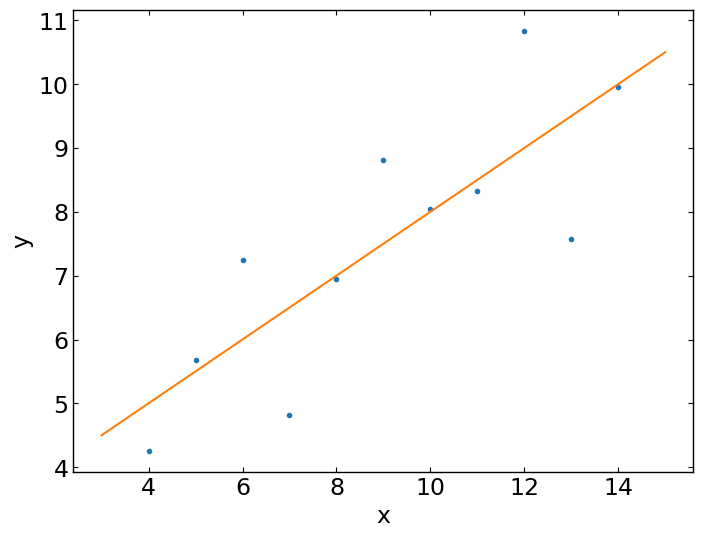

In [24]:
''' Linear Regression '''

# data allocation
x = anscombe_x[0]
y = anscombe_y[0]

# Perform linear regression: a, b
a, b = np.polyfit(x, y, 1)

# Print the slope and intercept
print(a, b)

# Generate theoretical x and y data: x_theor, y_theor
x_theor = np.array([3, 15])
y_theor = x_theor * a + b

fig, ax = plt.subplots()

# Plot the Anscombe data and theoretical line
ax.plot(x, y, marker='.', linestyle='none')
ax.plot(x_theor, y_theor)

# Label the axes
ax.set_xlabel('x')
ax.set_ylabel('y');

In [25]:
# Iterate through x,y pairs
for x, y in zip(anscombe_x, anscombe_y):
    # Compute the slope and intercept: a, b
    a, b = np.polyfit(x, y, 1)

    # Print the result
    print('slope:', a, 'intercept:', b)

slope: 0.5000909090909095 intercept: 3.0000909090909076
slope: 0.5000000000000004 intercept: 3.000909090909089
slope: 0.4997272727272731 intercept: 3.0024545454545453
slope: 0.49990909090909064 intercept: 3.0017272727272735


# Bootstrap confidence intervals

In [26]:
weather.head()

,yyyy,mm,tmax,tmin,af,rain,sun
0,1883,1,6.3,1.7,6.0,122.1,NaN
1,1883,2,8.0,2.8,2.0,69.8,NaN
2,1883,3,4.8,-1.6,23.0,29.6,NaN
3,1883,4,12.2,3.8,2.0,74.0,NaN
4,1883,5,14.7,6.2,0.0,31.2,NaN


In [27]:
''' group by year '''
weather_gr_yr = weather.groupby(by=('yyyy')).agg({'rain':sum})

# remove 2016 data
weather_gr_yr = weather_gr_yr[weather_gr_yr.index < 2016]

weather_gr_yr

,rain
yyyy,
1883,875.5
1884,648.2
1885,788.1
1886,940.3
1887,491.1
...,...
2011,572.4
2012,1146.4
2013,728.2


In [28]:
""" arange the dataset """
rainfall = weather_gr_yr.values.T[0]
print(rainfall)

[ 875.5  648.2  788.1  940.3  491.1  743.5  730.1  686.5  878.8  865.6
  654.9  831.5  798.1  681.8  743.8  689.1  752.1  837.2  710.6  749.2
  967.1  701.2  619.   747.6  803.4  645.6  804.1  787.4  646.8  997.1
  774.   734.5  835.   840.7  659.6  828.3  909.7  856.9  578.3  904.2
  883.9  740.1  773.9  741.4  866.8  871.1  712.5  919.2  927.9  809.4
  633.8  626.8  871.3  774.3  898.8  789.6  936.3  765.4  882.1  681.1
  661.3  847.9  683.9  985.7  771.1  736.6  713.2  774.5  937.7  694.5
  598.2  983.8  700.2  901.3  733.5  964.4  609.3 1035.2  718.   688.6
  736.8  643.3 1038.5  969.   802.7  876.6  944.7  786.6  770.4  808.6
  761.3  774.2  559.3  674.2  883.6  823.9  960.4  877.8  940.6  831.8
  906.2  866.5  674.1  998.1  789.3  915.   737.1  763.   666.7  824.5
  913.8  905.1  667.8  747.4  784.7  925.4  880.2 1086.9  764.4 1050.1
  595.2  855.2  726.9  785.2  948.8  970.6  896.   618.4  572.4 1146.4
  728.2  864.2  793. ]


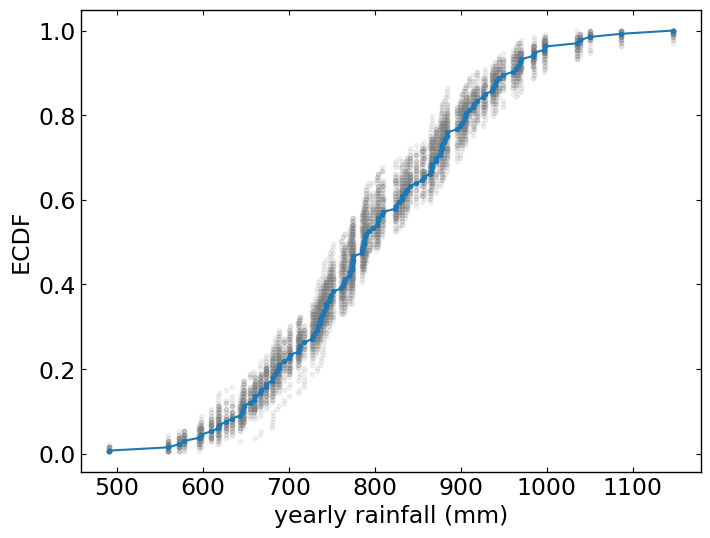

In [29]:
''' bootstrap samples'''

fig, ax = plt.subplots()

for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    ax.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
ax.plot(x, y, marker='.')

ax.set_xlabel('yearly rainfall (mm)')
ax.set_ylabel('ECDF');

10.510549150506188
10.358764199574097


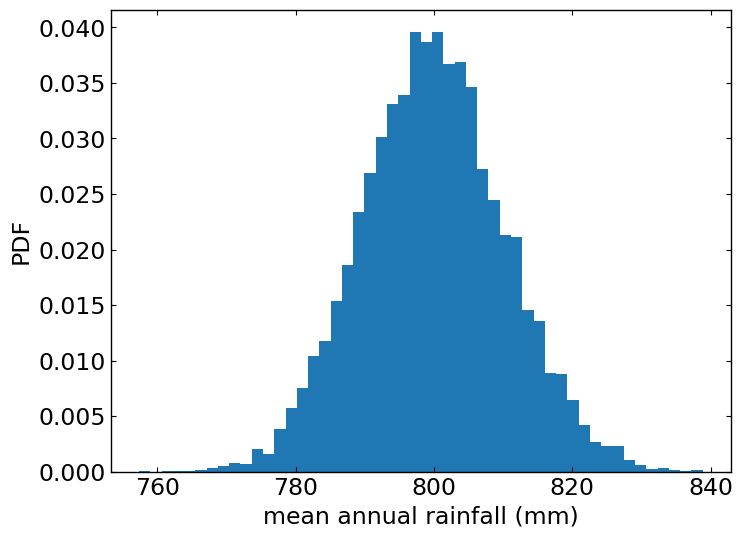

In [30]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, 10000)

# Compute and print standard error of mean (SEM)
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

fig, ax = plt.subplots()

# Make a histogram of the results
ax.hist(bs_replicates, bins=50, density=True)
ax.set_xlabel('mean annual rainfall (mm)')
ax.set_ylabel('PDF');

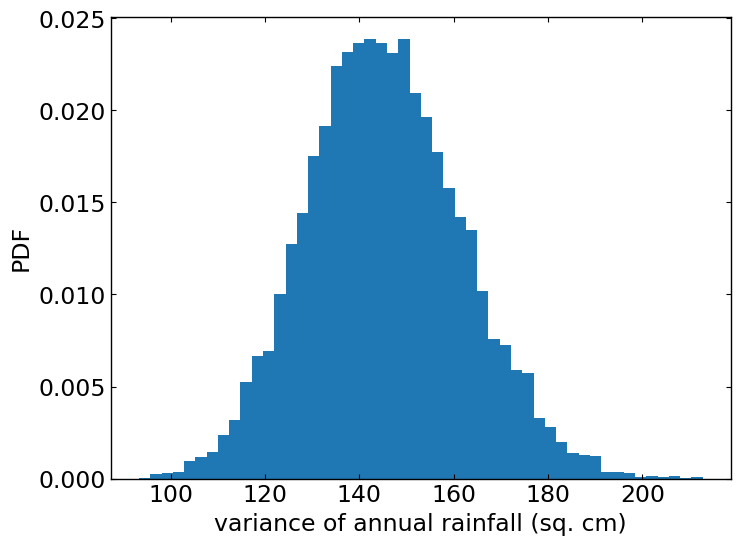

In [31]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, 10000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates / 100

fig, ax = plt.subplots()
# Make a histogram of the results
ax.hist(bs_replicates, bins=50, density=True)
ax.set_xlabel('variance of annual rainfall (sq. cm)')
ax.set_ylabel('PDF');

95% confidence interval = [663.65229084 869.79741036] games


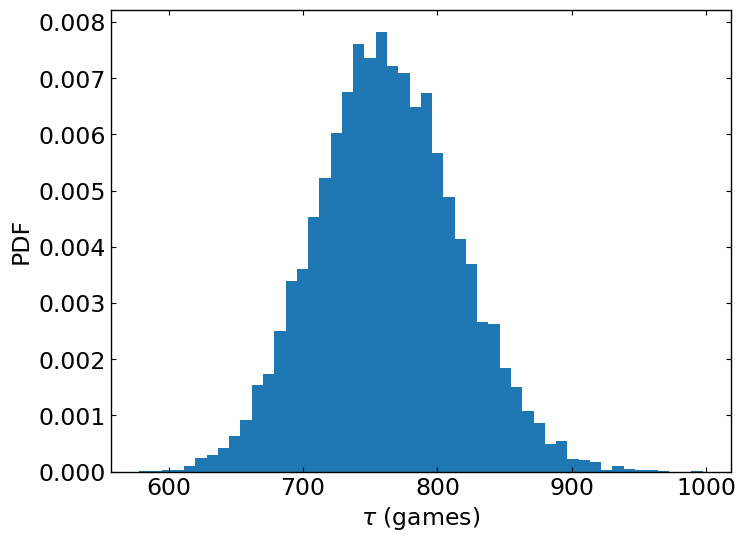

In [32]:
""" Confidence Interval on the rate of no-hitters """

# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, 10_000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

fig, ax = plt.subplots()
# Plot the histogram of the replicates
ax.hist(bs_replicates, bins=50, density=True)
ax.set_xlabel(r'$\tau$ (games)')
ax.set_ylabel('PDF');

## Pairs Bootstrap

[0.04389859 0.05528877]


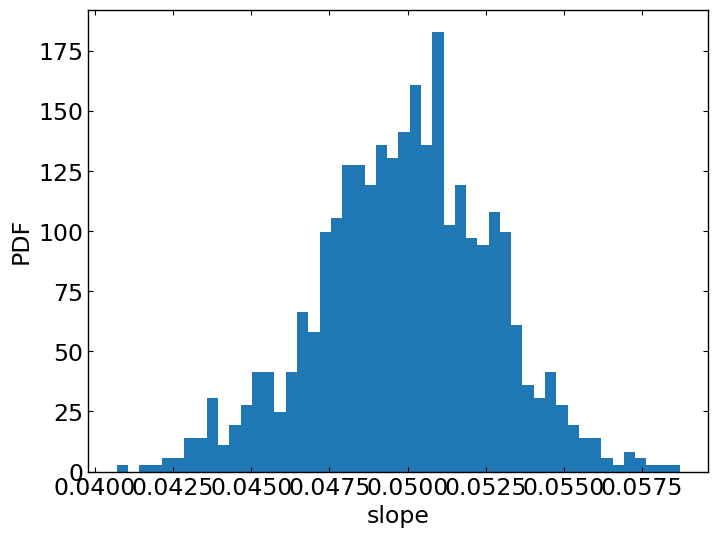

In [33]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, 1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

fig, ax = plt.subplots()

# Plot the histogram
ax.hist(bs_slope_reps, bins=50, density=True)
ax.set_xlabel('slope')
ax.set_ylabel('PDF');

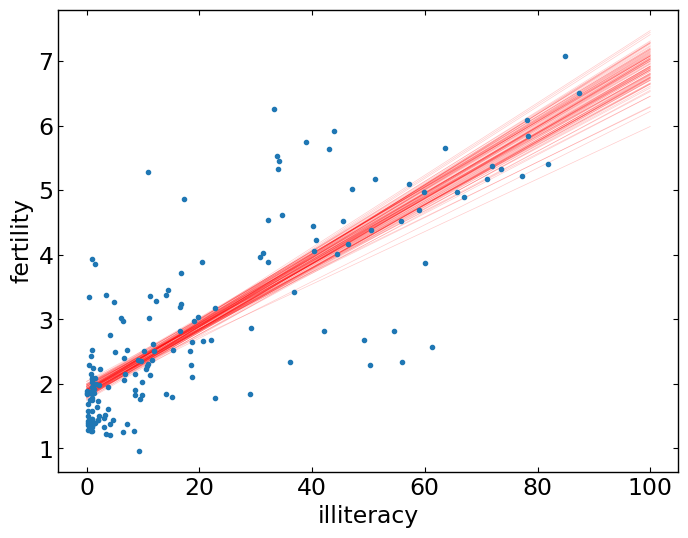

In [34]:
''' Visualize the bootstrap regression '''

# Generate array of x-values for bootstrap lines: x
x = np.array([0,100])

fig, ax = plt.subplots()

# Plot the bootstrap lines
for i in range(100):
    ax.plot(x, bs_slope_reps[i]*x + bs_intercept_reps[i],
            linewidth=0.5, alpha=0.2, color='red')

# Plot the data
ax.plot(illiteracy, fertility, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
ax.set_xlabel('illiteracy')
ax.set_ylabel('fertility');

# Introduction to hypothesis testing

In [35]:
weather[weather.mm == 6]

,yyyy,mm,tmax,tmin,af,rain,sun
5,1883,6,17.7,9.3,0.0,66.2,NaN
17,1884,6,18.2,8.7,0.0,39.7,NaN
29,1885,6,18.6,9.2,0.0,76.4,NaN
41,1886,6,17.3,8.5,0.0,26.5,NaN
53,1887,6,21.0,10.2,0.0,11.2,NaN
...,...,...,...,...,...,...,...
1553,2012,6,17.3,10.3,0.0,166.6,107.3
1565,2013,6,18.8,10.1,0.0,37.8,177.6
1577,2014,6,19.4,11.4,0.0,45.4,142.0
1589,2015,6,19.1,10.0,0.0,43.2,195.9


In [36]:
''' manange the dataset to numpy array '''
rain_june     = weather[weather.mm==6].rain.values
rain_november = weather[weather.mm==11].rain.values

# remove the data in 2016
rain_june = rain_june[:-1]
rain_november = rain_november[:-1]
print(rain_june)

[ 66.2  39.7  76.4  26.5  11.2  61.8   6.1  48.4  89.2 104.   34.   60.6
  57.1  79.1  90.9  32.3  63.8  78.2  27.5  43.4  30.1  17.3  77.5  44.9
  92.2  39.6  79.4  66.1  53.5  98.5  20.8  55.5  39.6  56.   65.1  14.8
  13.2  88.1   8.4  32.1  19.6  40.4   2.2  77.5 105.4  77.2  38.   27.1
 111.8  17.2  26.7  23.3  77.2  87.2  27.7  50.6  60.3  15.1   6.   29.4
  39.3  56.3  80.4  85.3  68.4  72.5  13.3  28.4  14.7  37.4  49.5  57.2
  85.9  82.1  31.8 126.6  30.7  41.4  33.9  13.5  99.1  70.2  91.8  61.3
  13.7  54.9  62.5  24.2  69.4  83.1  44.   48.5  11.9  16.6  66.4  90.
  34.9 132.8  33.4 225.    7.6  40.9  76.5  48.  140.   55.9  54.1  46.4
  68.6  52.2 108.3  14.6  11.3  29.8 130.9 152.4  61.   46.6  43.9  30.9
 111.1  68.5  42.2   9.8 285.6  56.7 168.2  41.2  47.8 166.6  37.8  45.4
  43.2]


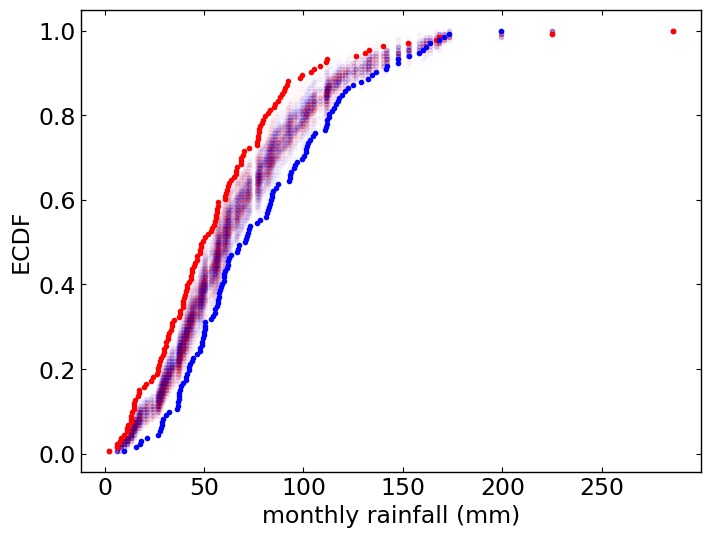

In [37]:
''' Visualizing permutation sampling '''

fig, ax = plt.subplots()

for i in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)

    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    ax.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    ax.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
ax.plot(x_1, y_1, marker='.', linestyle='none', color='red')
ax.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

ax.set_xlabel('monthly rainfall (mm)')
ax.set_ylabel('ECDF');

Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014) performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

Frog A is an adult and Frog B is a juvenile. The researchers measured the impact force of 20 strikes for each frog. 

In [38]:
frogs.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


In [39]:
print(frogs.columns)

Index(['date', 'ID', 'trial number', 'impact force (mN)', 'impact time (ms)',
       'impact force / body weight', 'adhesive force (mN)',
       'time frog pulls on target (ms)', 'adhesive force / body weight',
       'adhesive impulse (N-s)', 'total contact area (mm2)',
       'contact area without mucus (mm2)',
       'contact area with mucus / contact area without mucus',
       'contact pressure (Pa)', 'adhesive strength (Pa)'],
      dtype='object')


In [40]:
df = frogs.copy()

df.rename(columns={"impact force (mN)":"impact_force"}, inplace=True)

df.head()

,date,ID,trial number,impact_force,impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


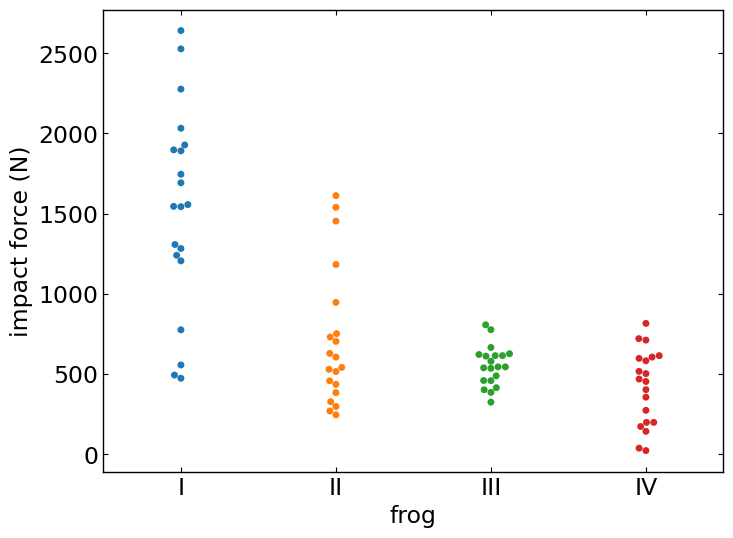

In [41]:
fig, ax = plt.subplots()

# Make bee swarm plot
ax = sns.swarmplot(x="ID", y="impact_force", data=df)

# Label axes
ax.set_xlabel('frog')
ax.set_ylabel('impact force (N)');

## P-value

In [42]:
frogs.head()

,date,ID,trial number,impact force (mN),impact time (ms),impact force / body weight,adhesive force (mN),time frog pulls on target (ms),adhesive force / body weight,adhesive impulse (N-s),total contact area (mm2),contact area without mucus (mm2),contact area with mucus / contact area without mucus,contact pressure (Pa),adhesive strength (Pa)
0,2013_02_26,I,3,1205,46,1.95,-785,884,1.27,-0.290,387,70,0.82,3117,-2030
1,2013_02_26,I,4,2527,44,4.08,-983,248,1.59,-0.181,101,94,0.07,24923,-9695
2,2013_03_01,I,1,1745,34,2.82,-850,211,1.37,-0.157,83,79,0.05,21020,-10239
3,2013_03_01,I,2,1556,41,2.51,-455,1025,0.74,-0.170,330,158,0.52,4718,-1381
4,2013_03_01,I,3,493,36,0.80,-974,499,1.57,-0.423,245,216,0.12,2012,-3975


In [43]:
""" manage dataset to numpy array """
force_a = frogs[frogs.ID=="II"]["impact force (mN)"].values / 1000
force_b = frogs[frogs.ID=="IV"]["impact force (mN)"].values / 1000

print(force_a)
print(force_b)

[1.612 0.605 0.327 0.946 0.541 1.539 0.529 0.628 1.453 0.297 0.703 0.269
 0.751 0.245 1.182 0.515 0.435 0.383 0.457 0.73 ]
[0.172 0.142 0.037 0.453 0.355 0.022 0.502 0.273 0.72  0.582 0.198 0.198
 0.597 0.516 0.815 0.402 0.605 0.711 0.614 0.468]


In [44]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0058


Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N. Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

In [45]:
force_c_mean = 0.55

# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + force_c_mean

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)

p =  0.0046


# Hypothesis test examples

## A/B Testing

The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yea. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

In [46]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = np.sum(dems) / len(dems)
    return frac

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(dems, reps, frac_yea_dems, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0002


We return to the no-hitter data set. In 1920, Major League Baseball implemented important rule changes that ended the so-called dead ball era. Importantly, the pitcher was no longer allowed to spit on or scuff the ball, an activity that greatly favors pitchers. In this problem you will perform an A/B test to determine if these rule changes resulted in a slower rate of no-hitters (i.e., longer average time between no-hitters) using the difference in mean inter-no-hitter time as your test statistic. The inter-no-hitter times for the respective eras are stored in the arrays nht_dead and nht_live, where "nht" is meant to stand for "no-hitter time."

In [47]:
""" data manipulation """
nht_dead = np.array([  -1,  894,   10,  130,    1,  934,   29,    6,  485,  254,  372,
         81,  191,  355,  180,  286,   47,  269,  361,  173,  246,  492,
        462, 1319,   58,  297,   31, 2970,  640,  237,  434,  570,   77,
        271,  563, 3365,   89,    0,  379,  221,  479,  367,  628,  843,
       1613, 1101,  215,  684,  814,  278,  324,  161,  219,  545,  715,
        966,  624,   29,  450,  107,   20,   91, 1325,  124, 1468,  104,
       1309,  429,   62, 1878, 1104,  123,  251,   93,  188,  983,  166,
         96,  702,   23,  524,   26,  299,   59,   39,   12,    2,  308,
       1114,  813,  887])

nht_live = np.array([ 645, 2088,   42, 2090,   11,  886, 1665, 1084, 2900, 2432,  750,
       4021, 1070, 1765, 1322,   26,  548, 1525,   77, 2181, 2752,  127,
       2147,  211,   41, 1575,  151,  479,  697,  557, 2267,  542,  392,
         73,  603,  233,  255,  528,  397, 1529, 1023, 1194,  462,  583,
         37,  943,  996,  480, 1497,  717,  224,  219, 1531,  498,   44,
        288,  267,  600,   52,  269, 1086,  386,  176, 2199,  216,   54,
        675, 1243,  463,  650,  171,  327,  110,  774,  509,    8,  197,
        136,   12, 1124,   64,  380,  811,  232,  192,  731,  715,  226,
        605,  539, 1491,  323,  240,  179,  702,  156,   82, 1397,  354,
        778,  603, 1001,  385,  986,  203,  149,  576,  445,  180, 1403,
        252,  675, 1351, 2983, 1568,   45,  899, 3260, 1025,   31,  100,
       2055, 4043,   79,  238, 3931, 2351,  595,  110,  215,    0,  563,
        206,  660,  242,  577,  179,  157,  192,  192, 1848,  792, 1693,
         55,  388,  225, 1134, 1172, 1555,   31, 1582, 1044,  378, 1687,
       2915,  280,  765, 2819,  511, 1521,  745, 2491,  580, 2072, 6450,
        578,  745, 1075, 1103, 1549, 1520,  138, 1202,  296,  277,  351,
        391,  950,  459,   62, 1056, 1128,  139,  420,   87,   71,  814,
        603, 1349,  162, 1027,  783,  326,  101,  876,  381,  905,  156,
        419,  239,  119,  129,  467])

In [48]:
# Compute the observed difference in mean inter-no-hitter times: nht_diff_obs
nht_diff_obs = diff_of_means(nht_dead, nht_live)

# Acquire 10,000 permutation replicates of difference in mean no-hitter time: perm_replicates
perm_replicates = draw_perm_reps(nht_dead, nht_live, diff_of_means, size=10_000)


# Compute and print the p-value: p
p = np.sum(perm_replicates <= nht_diff_obs)/len(perm_replicates)
print('p-val =', p)

p-val = 0.0002


## Hypothesis test on Pearson correlation

In [49]:
# Compute observed correlation: r_obs
r_obs = pearson_r(illiteracy, fertility)

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(illiteracy)

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, fertility)

# Compute p-value: p
p = np.sum(perm_replicates >= r_obs)/len(perm_replicates)
print('p-val =', p)

p-val = 0.0


you will investigate the effects of neonicotinoid insecticides on bee reproduction. These insecticides are very widely used in the United States to combat aphids and other pests that damage plants.

In a recent study, Straub, et al. (Proc. Roy. Soc. B, 2016) investigated the effects of neonicotinoids on the sperm of pollinating bees. In this and the next exercise, you will study how the pesticide treatment affected the count of live sperm per half milliliter of semen.

In [50]:
bees.head()

,Specimen,Treatment,Environment,TreatmentNCSS,Sample ID,Colony,Cage,Sample,Sperm Volume per 500 ul,Quantity,ViabilityRaw (%),Quality,Age (d),Infertil,AliveSperm,Quantity Millions,Alive Sperm Millions,Dead Sperm Millions
0,227,Control,Cage,1,C2-1-1,2,1,1,2150000,2150000,96.7263814616756,96.726381,14,0,2079617,2.1500,2.079617,0.070383
1,228,Control,Cage,1,C2-1-2,2,1,2,2287500,2287500,96.3498079760595,96.349808,14,0,2204001,2.2875,2.204001,0.083499
2,229,Control,Cage,1,C2-1-3,2,1,3,87500,87500,98.75,98.750000,14,0,86406,0.0875,0.086406,0.001094
3,230,Control,Cage,1,C2-1-4,2,1,4,1875000,1875000,93.2874208336941,93.287421,14,0,1749139,1.8750,1.749139,0.125861
4,231,Control,Cage,1,C2-1-5,2,1,5,1587500,1587500,97.7925061050061,97.792506,14,0,1552456,1.5875,1.552456,0.035044


In [51]:
control = bees[bees.Treatment=="Control"]["Alive Sperm Millions"].values * 2
treated = bees[bees.Treatment=="Pesticide"]["Alive Sperm Millions"].values * 2

print(treated)

[1.342686 1.058476 3.793784 0.40428  4.528388 2.142966 3.937742 0.1375
 6.919164 0.       3.597812 5.196538 2.78955  2.3229   1.090636 5.323916
 1.021618 0.931836 2.78     0.412202 1.180934 2.8674   0.       0.064354
 3.008348 0.876634 0.       4.971712 7.280658 4.79732  2.084956 3.251514
 1.9405   1.566192 0.58894  5.219658 0.977976 3.124584 1.297564 1.433328
 4.24337  0.880964 2.376566 3.763658 1.918426 3.74     3.841726 4.69964
 4.386876 0.       1.127432 1.845452 0.690314 4.185602 2.284732 7.237594
 2.185148 2.799124 3.43218  0.63354  1.142496 0.586    2.372858 1.80032
 3.329306 4.028804 3.474156 7.508752 2.032824 1.336556 1.906496 1.396046
 2.488104 4.759114 1.07853  3.19927  3.814252 4.275962 2.817056 0.552198
 3.27194  5.11525  2.064628 0.       3.34101  6.177322 0.       3.66415
 2.352582 1.531696]


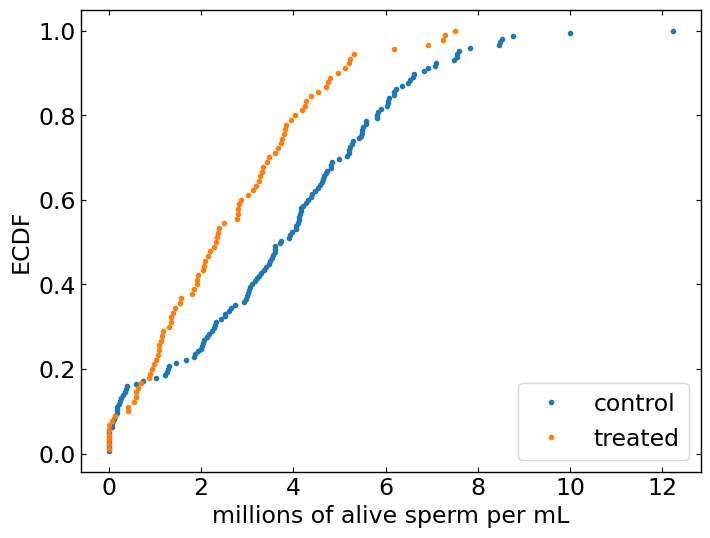

In [52]:
# Compute x,y values for ECDFs
x_control, y_control = ecdf(control)
x_treated, y_treated = ecdf(treated)

fig, ax = plt.subplots()

# Plot the ECDFs
ax.plot(x_control, y_control, marker='.', linestyle='none')
ax.plot(x_treated, y_treated, marker='.', linestyle='none')

# Add a legend
ax.legend(('control', 'treated'), loc='lower right')

# Label axes and show plot
ax.set_xlabel('millions of alive sperm per mL')
ax.set_ylabel('ECDF');

In [53]:
# Compute the difference in mean sperm count: diff_means
diff_means = np.mean(control) - np.mean(treated)

# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate([control, treated]))

# Generate shifted data sets
control_shifted = control - np.mean(control) + mean_count
treated_shifted = treated - np.mean(treated) + mean_count

# Generate bootstrap replicates
bs_reps_control = draw_bs_reps(control_shifted,
                       np.mean, size=10000)
bs_reps_treated = draw_bs_reps(treated_shifted,
                       np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_control - bs_reps_treated

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(control) - np.mean(treated)) \
            / len(bs_replicates)
print('p-value =', p)

p-value = 0.0


# Case Study

For your first foray into the Darwin finch data, you will study how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

In the next few problems, you will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

In [54]:
beaks_1975.head()

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [55]:
beaks_1975.columns

Index(['band', 'species', 'Beak length, mm', 'Beak depth, mm'], dtype='object')

In [56]:
""" data re-arrange """
beaks_1975_2 = beaks_1975.copy()
beaks_1975_2.rename(columns={'Beak length, mm':'blength', 'Beak depth, mm':'bdepth'}, inplace=True)
beaks_1975_2['year'] = 1975
beaks_1975_2.head()

,band,species,blength,bdepth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975


In [57]:
beaks_2012_2 = beaks_2012.copy()
beaks_2012_2['year'] = 2012

In [58]:
""" merge two dataset """
beaks = pd.concat([beaks_1975_2, beaks_2012_2])
beaks

,band,species,blength,bdepth,year
0,2,fortis,9.4,8.0,1975
1,9,fortis,9.2,8.3,1975
2,12,fortis,9.5,7.5,1975
3,15,fortis,9.5,8.0,1975
4,305,fortis,11.5,9.9,1975
...,...,...,...,...,...
243,21295,scandens,14.2,9.3,2012
244,21297,scandens,13.0,9.8,2012
245,21340,scandens,14.6,8.9,2012
246,21342,scandens,13.1,9.8,2012


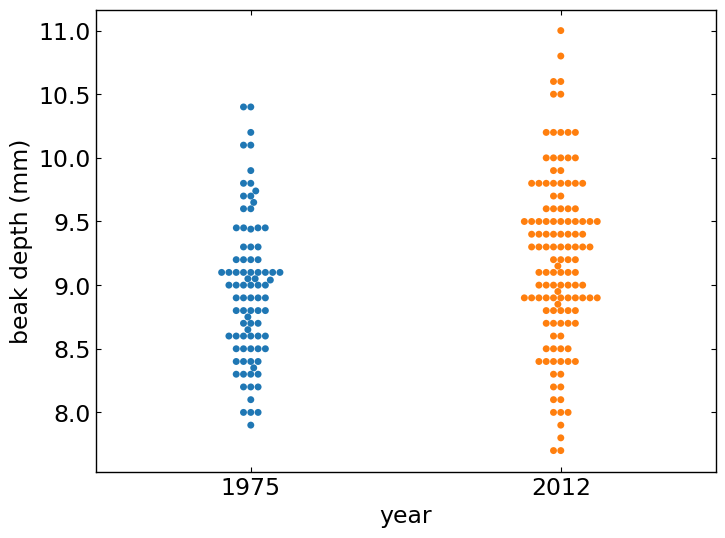

In [59]:
fig, ax = plt.subplots()

# Create bee swarm plot
ax = sns.swarmplot(x="year", y="bdepth", data=beaks[beaks.species=='scandens'])

ax.set_xlabel('year')
ax.set_ylabel('beak depth (mm)');

In [60]:
# beak depth
bd_1975 = beaks[(beaks.year==1975) & (beaks.species=='scandens')].bdepth.values
bd_2012 = beaks[(beaks.year==2012) & (beaks.species=='scandens')].bdepth.values
# beak length
bl_1975 = beaks[(beaks.year==1975) & (beaks.species=='scandens')].blength.values
bl_2012 = beaks[(beaks.year==2012) & (beaks.species=='scandens')].blength.values

In [61]:
print(bd_1975)

[ 8.4   8.8   8.4   8.    7.9   8.9   8.6   8.5   8.9   9.1   8.6   9.8
  8.2   9.    9.7   8.6   8.2   9.    8.4   8.6   8.9   9.1   8.3   8.7
  9.6   8.5   9.1   9.    9.2   9.9   8.6   9.2   8.4   8.9   8.5  10.4
  9.6   9.1   9.3   9.3   8.8   8.3   8.8   9.1  10.1   8.9   9.2   8.5
 10.2  10.1   9.2   9.7   9.1   8.5   8.2   9.    9.3   8.    9.1   8.1
  8.3   8.7   8.8   8.6   8.7   8.    8.8   9.    9.1   9.74  9.1   9.8
 10.4   8.3   9.44  9.04  9.    9.05  9.65  9.45  8.65  9.45  9.45  9.05
  8.75  9.45  8.35]


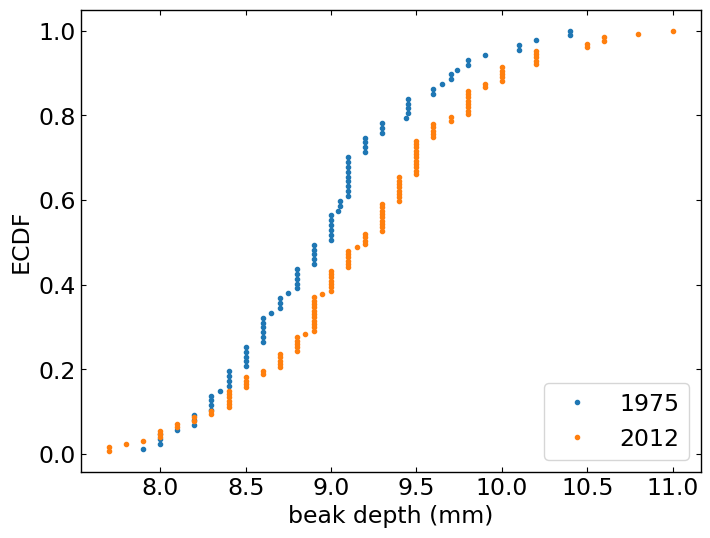

In [62]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

fig, ax = plt.subplots()

# Plot the ECDFs
ax.plot(x_1975, y_1975, marker='.', linestyle='none')
ax.plot(x_2012, y_2012, marker='.', linestyle='none')

ax.set_xlabel('beak depth (mm)')
ax.set_ylabel('ECDF')
ax.legend(('1975', '2012'), loc='lower right');

In [63]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10_000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10_000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05967226 0.38944932] mm


**Hypothesis test: Are beaks deeper in 2012?**

Your plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

In [64]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, size=10_000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, size=10_000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0046


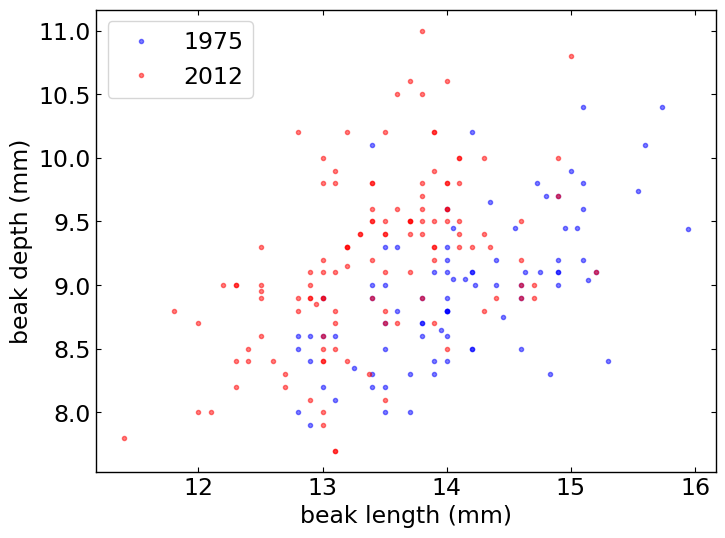

In [65]:
''' EDA of beak length and depth '''

fig, ax = plt.subplots()

# Make scatter plot of 1975 data
ax.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
ax.plot(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
ax.set_xlabel('beak length (mm)')
ax.set_ylabel('beak depth (mm)')
ax.legend(('1975', '2012'), loc='upper left');

In [66]:
''' Linear Regression '''

# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5,97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5,97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5,97.5])

intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5,97.5])


# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.3254032  0.58811989]
1975: intercept = 2.3908752365842263 conf int = [0.67000784 4.40072329]
2012: slope = 0.462630358835313 conf int = [0.33989291 0.60535488]
2012: intercept = 2.9772474982360198 conf int = [1.03792858 4.62029259]


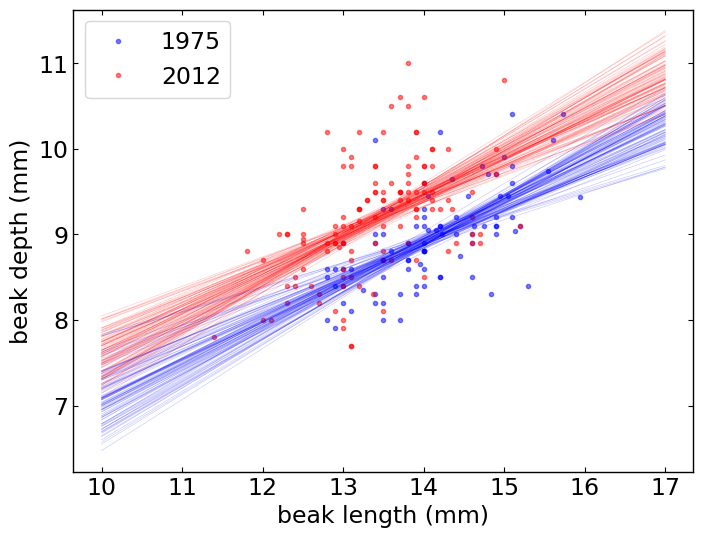

In [67]:
fig, ax = plt.subplots()

# Make scatter plot of 1975 data
ax.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
ax.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
ax.set_xlabel('beak length (mm)')
ax.set_ylabel('beak depth (mm)')
ax.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(100):
    ax.plot(x, x*bs_slope_reps_1975[i] + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    ax.plot(x, x*bs_slope_reps_2012[i] + bs_intercept_reps_2012[i], 
             linewidth=0.5, alpha=0.2, color='red');

In [68]:
""" Beak length to depth ratio """

# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10_000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10_000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5,99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5,99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)

1975: mean ratio = 1.5788823771858533 conf int = [1.55672661 1.60112763]
2012: mean ratio = 1.4658342276847767 conf int = [1.44471693 1.48753163]


The array `bd_parent_scandens` contains the average beak depth (in mm) of two parents of the species G. scandens. The array `bd_offspring_scandens` contains the average beak depth of the offspring of the respective parents. The arrays `bd_parent_fortis` and `bd_offspring_fortis` contain the same information about measurements from G. fortis birds.

In [69]:
''' data manipulation from datacamp '''
bd_parent_scandens = np.array([ 8.3318,  8.4035,  8.5317,  8.7202,  8.7089,  8.7541,  8.773 ,
        8.8107,  8.7919,  8.8069,  8.6523,  8.6146,  8.6938,  8.7127,
        8.7466,  8.7504,  8.7805,  8.7428,  8.7164,  8.8032,  8.8258,
        8.856 ,  8.9012,  8.9125,  8.8635,  8.8258,  8.8522,  8.8974,
        8.9427,  8.9879,  8.9615,  8.9238,  8.9351,  9.0143,  9.0558,
        9.0596,  8.9917,  8.905 ,  8.9314,  8.9465,  8.9879,  8.9804,
        9.0219,  9.052 ,  9.0407,  9.0407,  8.9955,  8.9992,  8.9992,
        9.0747,  9.0747,  9.5385,  9.4781,  9.4517,  9.3537,  9.2707,
        9.1199,  9.1689,  9.1425,  9.135 ,  9.1011,  9.1727,  9.2217,
        9.2255,  9.2821,  9.3235,  9.3198,  9.3198,  9.3198,  9.3273,
        9.3725,  9.3989,  9.4253,  9.4593,  9.4442,  9.4291,  9.2632,
        9.2293,  9.1878,  9.1425,  9.1275,  9.1802,  9.1765,  9.2481,
        9.2481,  9.1991,  9.1689,  9.1765,  9.2406,  9.3198,  9.3235,
        9.1991,  9.2971,  9.2443,  9.316 ,  9.2934,  9.3914,  9.3989,
        9.5121,  9.6176,  9.5535,  9.4668,  9.3725,  9.3348,  9.3763,
        9.3839,  9.4216,  9.4065,  9.3348,  9.4442,  9.4367,  9.5083,
        9.448 ,  9.4781,  9.595 ,  9.6101,  9.5686,  9.6365,  9.7119,
        9.8213,  9.825 ,  9.7609,  9.6516,  9.5988,  9.546 ,  9.6516,
        9.7572,  9.8854, 10.0023,  9.3914])

bd_parent_fortis = np.array([10.1  ,  9.55 ,  9.4  , 10.25 , 10.125,  9.7  ,  9.05 ,  7.4  ,
        9.   ,  8.65 ,  9.625,  9.9  ,  9.55 ,  9.05 ,  8.35 , 10.1  ,
       10.1  ,  9.9  , 10.225, 10.   , 10.55 , 10.45 ,  9.2  , 10.2  ,
        8.95 , 10.05 , 10.2  ,  9.5  ,  9.925,  9.95 , 10.05 ,  8.75 ,
        9.2  , 10.15 ,  9.8  , 10.7  , 10.5  ,  9.55 , 10.55 , 10.475,
        8.65 , 10.7  ,  9.1  ,  9.4  , 10.3  ,  9.65 ,  9.5  ,  9.7  ,
       10.525,  9.95 , 10.1  ,  9.75 , 10.05 ,  9.9  , 10.   ,  9.1  ,
        9.45 ,  9.25 ,  9.5  , 10.   , 10.525,  9.9  , 10.4  ,  8.95 ,
        9.4  , 10.95 , 10.75 , 10.1  ,  8.05 ,  9.1  ,  9.55 ,  9.05 ,
       10.2  , 10.   , 10.55 , 10.75 ,  8.175,  9.7  ,  8.8  , 10.75 ,
        9.3  ,  9.7  ,  9.6  ,  9.75 ,  9.6  , 10.45 , 11.   , 10.85 ,
       10.15 , 10.35 , 10.4  ,  9.95 ,  9.1  , 10.1  ,  9.85 ,  9.625,
        9.475,  9.   ,  9.25 ,  9.1  ,  9.25 ,  9.2  ,  9.95 ,  8.65 ,
        9.8  ,  9.4  ,  9.   ,  8.55 ,  8.75 ,  9.65 ,  8.95 ,  9.15 ,
        9.85 , 10.225,  9.825, 10.   ,  9.425, 10.4  ,  9.875,  8.95 ,
        8.9  ,  9.35 , 10.425, 10.   , 10.175,  9.875,  9.875,  9.15 ,
        9.45 ,  9.025,  9.7  ,  9.7  , 10.05 , 10.3  ,  9.6  , 10.   ,
        9.8  , 10.05 ,  8.75 , 10.55 ,  9.7  , 10.   ,  9.85 ,  9.8  ,
        9.175,  9.65 ,  9.55 ,  9.9  , 11.55 , 11.3  , 10.4  , 10.8  ,
        9.8  , 10.45 , 10.   , 10.75 ,  9.35 , 10.75 ,  9.175,  9.65 ,
        8.8  , 10.55 , 10.675,  9.95 ,  9.55 ,  8.825,  9.7  ,  9.85 ,
        9.8  ,  9.55 ,  9.275, 10.325,  9.15 ,  9.35 ,  9.15 ,  9.65 ,
       10.575,  9.975,  9.55 ,  9.2  ,  9.925,  9.2  ,  9.3  ,  8.775,
        9.325,  9.175,  9.325,  8.975,  9.7  ,  9.5  , 10.225, 10.025,
        8.2  ,  8.2  ,  9.55 ,  9.05 ,  9.6  ,  9.6  , 10.15 ,  9.875,
       10.485, 11.485, 10.985,  9.7  ,  9.65 ,  9.35 , 10.05 , 10.1  ,
        9.9  ,  8.95 ,  9.3  ,  9.95 ,  9.45 ,  9.5  ,  8.45 ,  8.8  ,
        8.525,  9.375, 10.2  ,  7.625,  8.375,  9.25 ,  9.4  , 10.55 ,
        8.9  ,  8.8  ,  9.   ,  8.575,  8.575,  9.6  ,  9.375,  9.6  ,
        9.95 ,  9.6  , 10.2  ,  9.85 ,  9.625,  9.025, 10.375, 10.25 ,
        9.3  ,  9.5  ,  9.55 ,  8.55 ,  9.05 ,  9.9  ,  9.8  ,  9.75 ,
       10.25 ,  9.1  ,  9.65 , 10.3  ,  8.9  ,  9.95 ,  9.5  ,  9.775,
        9.425,  7.75 ,  7.55 ,  9.1  ,  9.6  ,  9.575,  8.95 ,  9.65 ,
        9.65 ,  9.65 ,  9.525,  9.85 ,  9.05 ,  9.3  ,  8.9  ,  9.45 ,
       10.   ,  9.85 ,  9.25 , 10.1  ,  9.125,  9.65 ,  9.1  ,  8.05 ,
        7.4  ,  8.85 ,  9.075,  9.   ,  9.7  ,  8.7  ,  9.45 ,  9.7  ,
        8.35 ,  8.85 ,  9.7  ,  9.45 , 10.3  , 10.   , 10.45 ,  9.45 ,
        8.5  ,  8.3  , 10.   ,  9.225,  9.75 ,  9.15 ,  9.55 ,  9.   ,
        9.275,  9.35 ,  8.95 ,  9.875,  8.45 ,  8.6  ,  9.7  ,  8.55 ,
        9.05 ,  9.6  ,  8.65 ,  9.2  ,  8.95 ,  9.6  ,  9.15 ,  9.4  ,
        8.95 ,  9.95 , 10.55 ,  9.7  ,  8.85 ,  8.8  , 10.   ,  9.05 ,
        8.2  ,  8.1  ,  7.25 ,  8.3  ,  9.15 ,  8.6  ,  9.5  ,  8.05 ,
        9.425,  9.3  ,  9.8  ,  9.3  ,  9.85 ,  9.5  ,  8.65 ,  9.825,
        9.   , 10.45 ,  9.1  ,  9.55 ,  9.05 , 10.   ,  9.35 ,  8.375,
        8.3  ,  8.8  , 10.1  ,  9.5  ,  9.75 , 10.1  ,  9.575,  9.425,
        9.65 ,  8.725,  9.025,  8.5  ,  8.95 ,  9.3  ,  8.85 ,  8.95 ,
        9.8  ,  9.5  ,  8.65 ,  9.1  ,  9.4  ,  8.475,  9.35 ,  7.95 ,
        9.35 ,  8.575,  9.05 ,  8.175,  9.85 ,  7.85 ,  9.85 , 10.1  ,
        9.35 ,  8.85 ,  8.75 ,  9.625,  9.25 ,  9.55 , 10.325,  8.55 ,
        9.675,  9.15 ,  9.   ,  9.65 ,  8.6  ,  8.8  ,  9.   ,  9.95 ,
        8.4  ,  9.35 , 10.3  ,  9.05 ,  9.975,  9.975,  8.65 ,  8.725,
        8.2  ,  7.85 ,  8.775,  8.5  ,  9.4  ])

bd_offspring_scandens = np.array([ 8.419 ,  9.2468,  8.1532,  8.0089,  8.2215,  8.3734,  8.5025,
        8.6392,  8.7684,  8.8139,  8.7911,  8.9051,  8.9203,  8.8747,
        8.943 ,  9.0038,  8.981 ,  9.0949,  9.2696,  9.1633,  9.1785,
        9.1937,  9.2772,  9.0722,  8.9658,  8.9658,  8.5025,  8.4949,
        8.4949,  8.5633,  8.6013,  8.6468,  8.1532,  8.3734,  8.662 ,
        8.6924,  8.7456,  8.8367,  8.8595,  8.9658,  8.9582,  8.8671,
        8.8671,  8.943 ,  9.0646,  9.1405,  9.2089,  9.2848,  9.3759,
        9.4899,  9.4519,  8.1228,  8.2595,  8.3127,  8.4949,  8.6013,
        8.4646,  8.5329,  8.7532,  8.8823,  9.0342,  8.6392,  8.6772,
        8.6316,  8.7532,  8.8291,  8.8975,  8.9734,  9.0494,  9.1253,
        9.1253,  9.1253,  9.1785,  9.2848,  9.4595,  9.3608,  9.2089,
        9.2544,  9.3684,  9.3684,  9.2316,  9.1709,  9.2316,  9.0342,
        8.8899,  8.8291,  8.981 ,  8.8975, 10.4089, 10.1886,  9.7633,
        9.7329,  9.6114,  9.5051,  9.5127,  9.3684,  9.6266,  9.5354,
       10.0215, 10.0215,  9.6266,  9.6038,  9.4063,  9.2316,  9.338 ,
        9.262 ,  9.262 ,  9.4063,  9.4367,  9.0342,  8.943 ,  8.9203,
        8.7835,  8.7835,  9.057 ,  8.9354,  8.8975,  8.8139,  8.8671,
        9.0873,  9.2848,  9.2392,  9.2924,  9.4063,  9.3152,  9.4899,
        9.5962,  9.6873,  9.5203,  9.6646])

bd_offspring_fortis = np.array([10.7 ,  9.78,  9.48,  9.6 , 10.27,  9.5 ,  9.  ,  7.46,  7.65,
        8.63,  9.81,  9.4 ,  9.48,  8.75,  7.6 , 10.  , 10.09,  9.74,
        9.64,  8.49, 10.15, 10.28,  9.2 , 10.01,  9.03,  9.94, 10.5 ,
        9.7 , 10.02, 10.04,  9.43,  8.1 ,  9.5 ,  9.9 ,  9.48, 10.18,
       10.16,  9.08, 10.39,  9.9 ,  8.4 , 10.6 ,  8.75,  9.46,  9.6 ,
        9.6 ,  9.95, 10.05, 10.16, 10.1 ,  9.83,  9.46,  9.7 ,  9.82,
       10.34,  8.02,  9.65,  9.87,  9.  , 11.14,  9.25,  8.14, 10.23,
        8.7 ,  9.8 , 10.54, 11.19,  9.85,  8.1 ,  9.3 ,  9.34,  9.19,
        9.52,  9.36,  8.8 ,  8.6 ,  8.  ,  8.5 ,  8.3 , 10.38,  8.54,
        8.94, 10.  ,  9.76,  9.45,  9.89, 10.9 ,  9.91,  9.39,  9.86,
        9.74,  9.9 ,  9.09,  9.69, 10.24,  8.9 ,  9.67,  8.93,  9.3 ,
        8.67,  9.15,  9.23,  9.59,  9.03,  9.58,  8.97,  8.57,  8.47,
        8.71,  9.21,  9.13,  8.5 ,  9.58,  9.21,  9.6 ,  9.32,  8.7 ,
       10.46,  9.29,  9.24,  9.45,  9.35, 10.19,  9.91,  9.18,  9.89,
        9.6 , 10.3 ,  9.45,  8.79,  9.2 ,  8.8 ,  9.69, 10.61,  9.6 ,
        9.9 ,  9.26, 10.2 ,  8.79,  9.28,  8.83,  9.76, 10.2 ,  9.43,
        9.4 ,  9.9 ,  9.5 ,  8.95,  9.98,  9.72,  9.86, 11.1 ,  9.14,
       10.49,  9.75, 10.35,  9.73,  9.83,  8.69,  9.58,  8.42,  9.25,
       10.12,  9.31,  9.99,  8.59,  8.74,  8.79,  9.6 ,  9.52,  8.93,
       10.23,  9.35,  9.35,  9.09,  9.04,  9.75, 10.5 ,  9.09,  9.05,
        9.54,  9.3 ,  9.06,  8.7 ,  9.32,  8.4 ,  8.67,  8.6 ,  9.53,
        9.77,  9.65,  9.43,  8.35,  8.26,  9.5 ,  8.6 ,  9.57,  9.14,
       10.79,  8.91,  9.93, 10.7 ,  9.3 ,  9.93,  9.51,  9.44, 10.05,
       10.13,  9.24,  8.21,  8.9 ,  9.34,  8.77,  9.4 ,  8.82,  8.83,
        8.6 ,  9.5 , 10.2 ,  8.09,  9.07,  9.29,  9.1 , 10.19,  9.25,
        8.98,  9.02,  8.6 ,  8.25,  8.7 ,  9.9 ,  9.65,  9.45,  9.38,
       10.4 ,  9.96,  9.46,  8.26, 10.05,  8.92,  9.5 ,  9.43,  8.97,
        8.44,  8.92, 10.3 ,  8.4 ,  9.37,  9.91, 10.  ,  9.21,  9.95,
        8.84,  9.82,  9.5 , 10.29,  8.4 ,  8.31,  9.29,  8.86,  9.4 ,
        9.62,  8.62,  8.3 ,  9.8 ,  8.48,  9.61,  9.5 ,  9.37,  8.74,
        9.31,  9.5 ,  9.49,  9.74,  9.2 ,  9.24,  9.7 ,  9.64,  9.2 ,
        7.5 ,  7.5 ,  8.7 ,  8.31,  9.  ,  9.74,  9.31, 10.5 ,  9.3 ,
        8.12,  9.34,  9.72,  9.  ,  9.65,  9.9 , 10.  , 10.1 ,  8.  ,
        9.07,  9.75,  9.33,  8.11,  9.36,  9.74,  9.9 ,  9.23,  9.7 ,
        8.2 ,  9.35,  9.49,  9.34,  8.87,  9.03,  9.07,  9.43,  8.2 ,
        9.19,  9.  ,  9.2 ,  9.06,  9.81,  8.89,  9.4 , 10.45,  9.64,
        9.03,  8.71,  9.91,  8.33,  8.2 ,  7.83,  7.14,  8.91,  9.18,
        8.8 ,  9.9 ,  7.73,  9.25,  8.7 ,  9.5 ,  9.3 ,  9.05, 10.18,
        8.85,  9.24,  9.15,  9.98,  8.77,  9.8 ,  8.65, 10.  ,  8.81,
        8.01,  7.9 ,  9.41, 10.18,  9.55,  9.08,  8.4 ,  9.75,  8.9 ,
        9.07,  9.35,  8.9 ,  8.19,  8.65,  9.19,  8.9 ,  9.28, 10.58,
        9.  ,  9.4 ,  8.91,  9.93, 10.  ,  9.37,  7.4 ,  9.  ,  8.8 ,
        9.18,  8.3 , 10.08,  7.9 ,  9.96, 10.4 ,  9.65,  8.8 ,  8.65,
        9.7 ,  9.23,  9.43,  9.93,  8.47,  9.55,  9.28,  8.85,  8.9 ,
        8.75,  8.63,  9.  ,  9.43,  8.28,  9.23, 10.4 ,  9.  ,  9.8 ,
        9.77,  8.97,  8.37,  7.7 ,  7.9 ,  9.5 ,  8.2 ,  8.8 ])

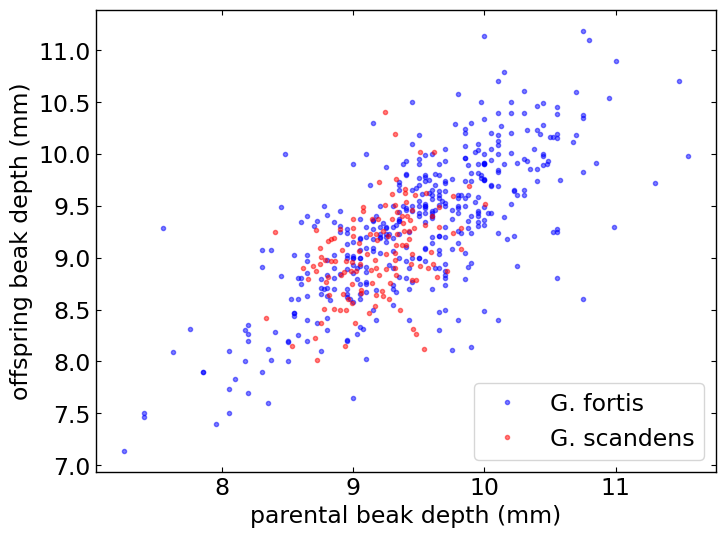

In [70]:
''' EDA of heritability '''

fig, ax = plt.subplots()

# Make scatter plots
ax.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
ax.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

ax.set_xlabel('parental beak depth (mm)')
ax.set_ylabel('offspring beak depth (mm)')
ax.legend(('G. fortis', 'G. scandens'), loc='lower right');

**Correlation of offspring and parental data**

In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

In [71]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, 1000)

bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, 1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5,97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5,97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)

G. scandens: 0.4117063629401258 [0.28114522 0.55186026]
G. fortis: 0.7283412395518486 [0.66716345 0.7791389 ]


**Measuring heritability**

Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. In this exercise, you will estimate the heritability and perform a pairs bootstrap calculation to get the 95% confidence interval.

In [72]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[1,0] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5,97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5,97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. scandens: 0.5485340868685982 [0.35159687 0.74984943]
G. fortis: 0.7229051911438155 [0.64286124 0.78727894]


**Is beak depth heritable at all in G. scandens?**

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. You will test that hypothesis here. To do this, you will do a pairs permutation test.

In [73]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10_000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val =', p)

p-val = 0.0
